In [1]:
import tensorflow as tf
import pickle
import os

## Predefine tensorflow graph

#### attention class

In [2]:
class Attention(tf.keras.Model):
    ''' How to use attention
        In call func:
            - inputs:
                    - features: (from the output of encoder) 
                    - state: (from the hidden state of decoder)
            - return:
                    - context_vector: need to be pass into decoder
                    - attn_weights: use for visualization on the image,
                                    you can see which part of the image
                                    contributes to a specific word
    '''
    
    def __init__(self, units):
        super(Attention, self).__init__()
        # for image features
        self.W1 = tf.keras.layers.Dense(units)
        # for decoder hidden state
        self.W2 = tf.keras.layers.Dense(units)
        # for attention score
        self.V  = tf.keras.layers.Dense(1)
        
    def call(self, features, state):
        # original features (bs,64,2048) are encoded by Encoder
        # so features: (bs, 64, units)
        
        # state: (bs, 1, units in the decoder)
        state = tf.expand_dims(state, 1)
        
        # attn_scores: (bs, 64, units)
        attn_scores  = tf.nn.tanh(self.W1(features) + self.W2(state))
        
        # self.V(): (bs, 64, 1)
        # attn_weights: (bs, 64, 1)
        attn_weights = tf.nn.softmax(self.V(attn_scores), axis=1)
        
        # context_vector: (bs, 64, units)
        context_vector = attn_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attn_weights

#### encoder class

In [3]:
class Encoder(tf.keras.Model):
    
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
    
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### decoder class

In [4]:
class Decoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, units):
        super(Decoder, self).__init__()
        # use for decoder gru
        self.units = units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.attention = Attention(self.units)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x, features, state):
        # input x: (bs, 1)
        # encoded word x: (bs, 1, embedding_dim)
        x = self.embedding(x)
        
        # context_vector: (bs, 256)
        # attn_weights: (bs, 64, 1)
        context_vector, attn_weights = self.attention(features, state)
        
        # combine encoded word and context_vector
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # pass x into GRU
        output, state = self.gru(x)
        
        x = self.fc1(output)
        
        x = tf.reshape(x, (-1, x.shape[2]))
        
        x = self.fc2(x)
        
        return x, state, attn_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### define hyperparameters

In [5]:
top_k = 8000
embedding_dim = 512
units = 256
vocab_size = top_k + 1
vocab_size

8001

### load tokenizer

In [6]:
pickle_in = open(os.path.join('imgcap_model', 'tokenizer.pickle'), 'rb')
tokenizer = pickle.load(pickle_in)

### load model

In [7]:
def load_inceptionv3():
    
    pretrained = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                                weights='imagenet')
    feature_extractor = tf.keras.Model(pretrained.input,
                                       pretrained.layers[-1].output)
    return feature_extractor

fea_ext = load_inceptionv3()

In [8]:
encoder = Encoder(embedding_dim)
decoder = Decoder(vocab_size, embedding_dim, units)

# You need to modify the directory

In [9]:
encoder.load_weights(os.path.join('imgcap_model', 'version_1', 'encoder_weights'))
decoder.load_weights(os.path.join('imgcap_model', 'version_1', 'decoder_weights'))

### test data function

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# main = 'security_image'
# new_jpegs = os.listdir(main)
# new_jpegs = [os.path.join(main, f) for f in new_jpegs]

In [12]:
def preprocess_image(jpeg_path):
    img = tf.io.read_file(jpeg_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img_tensor = tf.keras.applications.inception_v3.preprocess_input(img)
    img_tensor = fea_ext(img_tensor[tf.newaxis, ...])
    return img_tensor, img

def gencap(jpeg_path):
    
    Cap = []
    Attn = []
    
    feature, img = preprocess_image(jpeg_path)
    feature = encoder(feature)
    feature = tf.reshape(feature, (1, -1, feature.shape[-1]))
    
#     rand = tf.random.uniform((1, 256), -2., 2.)
    state = decoder.reset_state(batch_size=1)#+rand
#     print(state)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    
    for i in range(40):
        pred, state, attn = decoder(dec_input, feature, state)
        pred = tf.argmax(pred, -1).numpy()[0]
        
        if tokenizer.index_word[pred] == '<end>':
            return Cap, Attn, img.numpy().astype(np.uint8)
        
        Cap.append(tokenizer.index_word[pred])
        Attn.append(attn.numpy())
        dec_input = tf.expand_dims([pred], 1)
        
    return Cap, Attn, img.numpy().astype(np.uint8)

def plot_attn_maps(caption, attn, image):
    
    lens = len(caption)
    rows = 2
    cols = lens//rows+1
    fig = plt.figure(figsize=(15, 6))
    
    for i in range(lens):
        ax = fig.add_subplot(rows, cols, i+1)
        img = ax.imshow(image)
        ax.imshow(np.resize(attn[i], (8, 8)),
                  cmap='gray',
                  alpha=0.6,
                  extent=img.get_extent())
        ax.set_title(caption[i], fontsize=20)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# You need to modify below
new_jpegs is a variable which has all your image directories.

In [13]:
new_jpegs = os.listdir('new_images')
new_jpegs = [os.path.join('new_images', f) for f in new_jpegs]

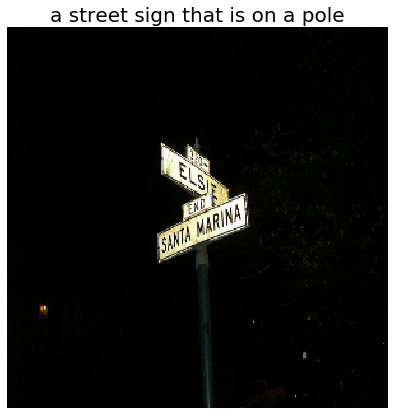

In [14]:
# tasty_data = os.path.join('new_images', 'tasty_data.jpg')
C, A, img = gencap(new_jpegs[7])
plt.figure(figsize=(10, 7))
plt.imshow(img)
plt.axis('off')
plt.title(' '.join(C), fontsize=20)
plt.show()

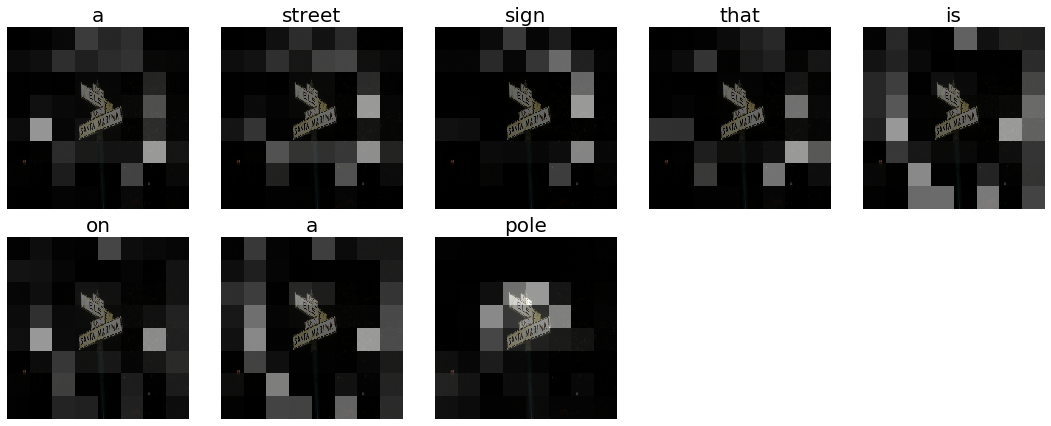

In [15]:
plot_attn_maps(C, A, img)